<a href="https://colab.research.google.com/github/beangoben/TB_project/blob/ashton/relationships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/beangoben/rdkit_colab/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
import colab_utils

--2020-07-13 06:42:33--  https://raw.githubusercontent.com/beangoben/rdkit_colab/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7169 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2020-07-13 06:42:33 (64.9 MB/s) - ‘colab_utils.py’ saved [7169/7169]



In [ ]:
github_repo = 'https://github.com/beangoben/rdkit_colab'
# If working in a private colab repo, 
# save a id_rsa file in gdrive or dropbox, etc. and run copy_ssh_key
colab_utils.copy_ssh_key('https://www.dropbox.com/s/h6aw94l7sz763sz/id_rsa_colab?dl=1')
colab_utils.clone_repo(github_repo)
colab_utils.conda_install_from_yaml()
colab_utils.pip_install_from_yaml()

CMD: git clone --recursive https://github.com/beangoben/rdkit_colab
Ignoring: conda install already exists in {CONDA_DIR}!
pip installing ['e3fp', 'selfies']
CMD: pip install  e3fp
Installing build dependencies: started
Installing build dependencies: finished with status 'done'
Getting requirements to build wheel: started
Getting requirements to build wheel: finished with status 'done'
Preparing wheel metadata: started
Preparing wheel metadata: finished with status 'done'
Using cached Cython-0.29.21-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
Created wheel for e3fp: filename=e3fp-1.2.1-cp37-cp37m-linux_x86_64.whl size=1317435 sha256=0899cca08e6fb961a92aefd05061682a0e90e0fcf209167b1d15aa806c9ef478
Stored in directory: /root/.cache/pip/wheels/17/4b/6e/bcb2040f207a2f7647a74ef7d40ff8171d90a795c2149bb313
Created wheel for sdaxen-python-utilities: filename=sdaxen_python_utilities-0.1.4-py3-none-any.whl size=12372 sha256=ac574655a2d256c22434a1504be49d79391c3530976d7e23b0306f43f213b3ed
Stored in

In [12]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
import scipy.stats as stats
import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.cluster
import pandas as pd
import numpy as np
from IPython.display import display, HTML 
np.set_printoptions(threshold=sys.maxsize)

# utils
from tqdm.autonotebook import tqdm
from collections import OrderedDict
import itertools

# rdkit stuff
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

tqdm.pandas()
sns.set_context('talk', font_scale=1.5)
sns.set_style("white")
plt.rc('lines', linewidth=2)
plt.rc('figure', figsize=(10,5))
import altair as alt

#google drive stuff
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [13]:
all = pd.read_csv('/content/drive/My Drive/Extracurricular/Internships/Research/TB Internship/FullMerged.csv')

In [ ]:
all = all.loc[all.concentration == 30]
all['mol'] = all.SMILES.apply(Chem.MolFromSmiles)
all['fingerprints'] = all.mol.apply(lambda x: AllChem.GetMorganFingerprint(x,2))
display(all.head())
display(all.info())
display(all.strain.unique())

In [16]:
def tani(f1, f2):
  return DataStructs.TanimotoSimilarity(f1,f2)

In [ ]:
r_value_list = []
index = 0
for strain in all.strain.unique():
  print(str(index) + " " + strain)
  df = all.loc[all.strain == strain]
  fps = np.array(df.fingerprints.values.tolist())
  zscores = np.array(df.z_score.values.tolist())

  sim_lists = []
  for ref in fps:
    sim = []
    for fp in fps:
      sim.append(tani(ref, fp))
    sim_lists.append(sim)


  diff_lists = []
  for zref in zscores:
    diff = []
    for z in zscores:
      diff.append(np.linalg.norm(zref - z))
    diff_lists.append(diff)

  sim_lists = np.array(sim_lists)
  diff_lists = np.array(diff_lists)

  r_values = []
  for sim,diff in zip(sim_lists, diff_lists):
    slope, intercept, r_value, p_value, std_err = stats.linregress(sim,diff)
    r_values.append(r_value)
  r_value_list.append(np.array(r_values))
  index = index + 1

In [26]:
average_r_values = []
for r_values in r_value_list:
  average_r_values.append(np.mean(r_values))

In [45]:
df = pd.DataFrame({'strain': all.strain.unique(), 'r_values': r_value_list}, columns=['strain', 'r_values'])

In [47]:
df['means'] = df.r_values.apply(lambda x: np.mean(x))

In [48]:
df

,strain,r_values,means
0,aceE,"[-0.04591916056001836, 0.006728393003373894, 0...",-0.015751
1,adoK,"[-0.01908665129818436, -0.05217014747993693, 0...",-0.019576
2,alaS,"[-0.0011869970978541113, -0.009679467461636504...",-0.017249
3,alr,"[-0.014952093965463062, -0.009460334459587166,...",-0.011390
4,argC,"[0.009215921746126244, 0.0025392657941653994, ...",-0.015543
...,...,...,...
97,topA,"[-0.01955480072421771, -0.013261955781220008, ...",-0.008733
98,tpi,"[0.0193127573808587, -0.08978762222369466, -0....",-0.031490
99,trpA,"[-0.03176102022579162, 0.01978374312493982, 0....",-0.015906
100,trpG,"[-0.02923838476042113, -0.021310559519278467, ...",-0.018538


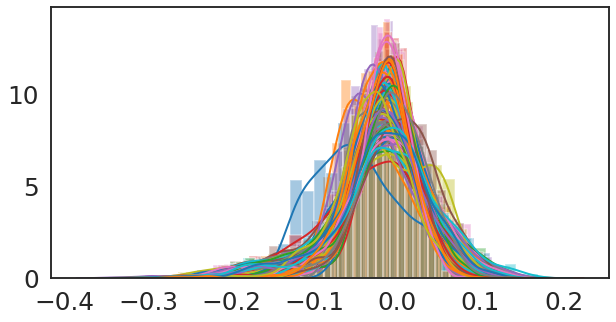

In [43]:
for li in dataset.r_values:
  x = li
  display(sns.distplot(x))

In [50]:
df.loc[df['means'] < -.04]


,strain,r_values,means
30,glcB,"[0.01082390801450331, -0.12128414640938054, 0....",-0.049342
